## Project 1 - Implementing CNN architectures on CIFAR 100 dataset

This notebook focuses on training CIFAR 100 dataset using Convolutional Neural Networks and it's architecture variants. <br> 

Network details:

*   Architecture: ResNet18
*   Regularizer: Dropout
*   Optimizer: SGD
*   Metrics: Precision, Recall, Accuracy


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
torch.manual_seed(0)
random.seed(0)

### Data loading and pre-processing

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding = 4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
])

In [ ]:
trainset = torchvision.datasets.CIFAR100(root='/drive/My Drive/Colab Notebooks/CSE 676', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=200, shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR100(root='/drive/My Drive/Colab Notebooks/CSE 676', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=200, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
len(trainset), len(testset), trainset[0][0].shape

(50000, 10000, torch.Size([3, 32, 32]))

In [ ]:
classes = trainset.classes
classes

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly',
 'camel',
 'can',
 'castle',
 'caterpillar',
 'cattle',
 'chair',
 'chimpanzee',
 'clock',
 'cloud',
 'cockroach',
 'couch',
 'crab',
 'crocodile',
 'cup',
 'dinosaur',
 'dolphin',
 'elephant',
 'flatfish',
 'forest',
 'fox',
 'girl',
 'hamster',
 'house',
 'kangaroo',
 'keyboard',
 'lamp',
 'lawn_mower',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'man',
 'maple_tree',
 'motorcycle',
 'mountain',
 'mouse',
 'mushroom',
 'oak_tree',
 'orange',
 'orchid',
 'otter',
 'palm_tree',
 'pear',
 'pickup_truck',
 'pine_tree',
 'plain',
 'plate',
 'poppy',
 'porcupine',
 'possum',
 'rabbit',
 'raccoon',
 'ray',
 'road',
 'rocket',
 'rose',
 'sea',
 'seal',
 'shark',
 'shrew',
 'skunk',
 'skyscraper',
 'snail',
 'snake',
 'spider',
 'squirrel',
 'streetcar',
 'sunflower',
 'sweet_pepper',
 'table',
 'tank',
 'telephone',
 'television',
 'tig

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


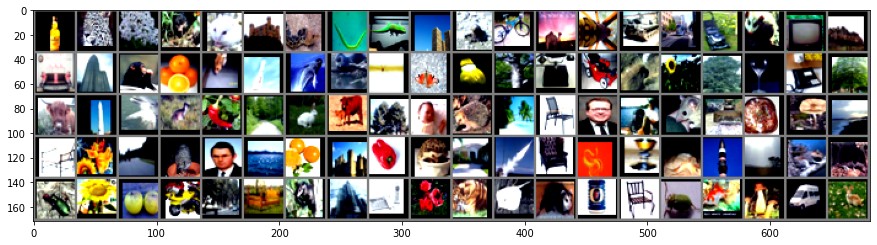

In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(15,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[0:100], nrow=20, padding=2))

### Construct ResNet18 network

In [5]:
def conv3x3(in_channels, out_channels, stride=1):
    """3x3 kernel size with padding convolutional layer in ResNet BasicBlock."""
    return nn.Conv2d(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=3,
        stride=stride,
        padding=1,
        bias=False)

In [6]:
class BasicBlock(nn.Module):
    """Basic Block of ReseNet."""

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        """Basic Block of ReseNet Builder."""
        super(BasicBlock, self).__init__()

        # First conv3x3 layer
        self.conv1 = conv3x3(in_channels, out_channels, stride)

        #  Batch Normalization
        # self.bn1 = nn.BatchNorm2d(num_features=out_channels)

        # ReLU Activation Function
        self.relu = nn.ReLU(inplace=True)

        # Second conv3x3 layer
        self.conv2 = conv3x3(out_channels, out_channels)

        #  Batch Normalization
        # self.bn2 = nn.BatchNorm2d(num_features=out_channels)

        # downsample for `residual`
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        # out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        # out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        return out

In [7]:
# Architecture code: https://github.com/dipuk0506/SpinalNet
class ResNet18(nn.Module):
    """Residual Neural Network."""

    def __init__(self, block, duplicates, num_classes=100):
        """Residual Neural Network Builder."""
        super(ResNet18, self).__init__()

        self.in_channels = 32
        self.conv1 = conv3x3(in_channels=3, out_channels=32)
        # self.bn = nn.BatchNorm2d(num_features=32)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(p=0.01)

        # block of Basic Blocks
        self.conv2_x = self._make_block(block, duplicates[0], out_channels=32)
        self.conv3_x = self._make_block(block, duplicates[1], out_channels=64, stride=2)
        self.conv4_x = self._make_block(block, duplicates[2], out_channels=128, stride=2)
        self.conv5_x = self._make_block(block, duplicates[3], out_channels=256, stride=2)

        self.maxpool = nn.MaxPool2d(kernel_size=4, stride=1)
        self.fc_layer = nn.Linear(256, num_classes)

        # initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal(m.weight.data, mode='fan_out')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def _make_block(self, block, duplicates, out_channels, stride=1):
        """
        Create Block in ResNet.
        Args:
            block: BasicBlock
            duplicates: number of BasicBlock
            out_channels: out channels of the block
        Returns:
            nn.Sequential(*layers)
        """
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride)
                # , nn.BatchNorm2d(num_features=out_channels)
            )

        layers = []
        layers.append(
            block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, duplicates):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        # out = self.bn(out)
        out = self.relu(out)
        out = self.dropout(out)

        # Stacked Basic Blocks
        out = self.conv2_x(out)
        out = self.conv3_x(out)
        out = self.conv4_x(out)
        out = self.conv5_x(out)
        
        out = self.maxpool(out)
        out = out.view(out.size(0), -1)
        out = out.view(out.size(0), -1)
        out = self.fc_layer(out)

        return out

In [8]:
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [9]:
model = ResNet18(BasicBlock, [2,2,2,2]).to(device)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [10]:
print(model)

ResNet18(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (relu): ReLU(inplace=True)
  (dropout): Dropout2d(p=0.01, inplace=False)
  (conv2_x): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (conv3_x): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (downsample): Sequential(
        (

### Train the model

In [ ]:
epochs = 300
patience = 20
epochs_no_improve = 0
early_stop = False
min_train_loss = np.Inf
learning_rate = 0.001
total_step = len(train_loader)

In [ ]:
accuracy_train, accuracy_test = 0, 0
train_losses, test_losses = [], []
train_accuracy, test_accuracy = [], []
test_predictions, test_labels = [], []

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-3)

In [ ]:
for epoch in range(epochs):
    training_loss = 0
    train_correct = 0
    train_total = 0
    _train_loss = 0

    if epochs_no_improve == patience:
      print('Early stopped!')
      break

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        training_loss += loss.item()

        predicted = torch.max(outputs.data, 1)[1].to(device)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        accuracy_train = accuracy_train if accuracy_train > train_correct / train_total else train_correct / train_total

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    else:
        test_loss = 0
        test_correct = 0
        test_total = 0

        # Turn off gradients for validation, saves memory and computations. Test the model
        with torch.no_grad():
            model.eval()
            for images, labels in test_loader:
                test_labels.append(labels)
                images = images.to(device)
                labels = labels.to(device)
                        
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                predicted = torch.max(outputs.data, 1)[1].to(device)
                test_predictions.append(predicted)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
            
            if accuracy_test > test_correct / test_total:
                current_lr = learning_rate * np.asscalar(pow(np.random.rand(1),5))
                update_lr(optimizer, current_lr)
            else:
                accuracy_test = test_correct / test_total
                        
            model.train()

            _train_loss = training_loss / len(train_loader)
            train_losses.append(_train_loss)
            test_losses.append(test_loss / len(test_loader))

            train_accuracy.append((train_correct / train_total) * 100)
            test_accuracy.append((test_correct / test_total) * 100)

            print("Epoch: {}/{}".format(epoch + 1, epochs), " | Training Loss: {:.3f}".format(train_losses[-1]), " | Training Accuracy: {:.3f}".format(100 * train_correct / train_total), " | Best Training Accuracy: {: .3f}".format(100 * accuracy_train),
                  " | Test Loss: {:.3f}".format(test_losses[-1]), " | Testing Accuracy: {:.3f}".format(100 * test_correct / test_total), " | Best Testing Accuracy: {: .3f}".format(100 * accuracy_test))
      
        if _train_loss < min_train_loss:
          epochs_no_improve = 0
          min_train_loss = _train_loss
        else:
          epochs_no_improve += 1

Epoch: 1/300  | Training Loss: 4.722  | Training Accuracy: 2.872  | Best Training Accuracy:  2.872  | Test Loss: 4.188  | Testing Accuracy: 7.130  | Best Testing Accuracy:  7.130
Epoch: 2/300  | Training Loss: 4.052  | Training Accuracy: 8.738  | Best Training Accuracy:  8.738  | Test Loss: 3.884  | Testing Accuracy: 11.050  | Best Testing Accuracy:  11.050
Epoch: 3/300  | Training Loss: 3.828  | Training Accuracy: 12.208  | Best Training Accuracy:  13.500  | Test Loss: 3.686  | Testing Accuracy: 14.640  | Best Testing Accuracy:  14.640
Epoch: 4/300  | Training Loss: 3.674  | Training Accuracy: 14.486  | Best Training Accuracy:  14.500  | Test Loss: 3.588  | Testing Accuracy: 16.370  | Best Testing Accuracy:  16.370
Epoch: 5/300  | Training Loss: 3.532  | Training Accuracy: 17.190  | Best Training Accuracy:  18.500  | Test Loss: 3.474  | Testing Accuracy: 18.740  | Best Testing Accuracy:  18.740
Epoch: 6/300  | Training Loss: 3.420  | Training Accuracy: 19.238  | Best Training Accuracy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Epoch: 14/300  | Training Loss: 2.820  | Training Accuracy: 30.020  | Best Training Accuracy:  30.897  | Test Loss: 2.887  | Testing Accuracy: 28.840  | Best Testing Accuracy:  29.020
Epoch: 15/300  | Training Loss: 2.749  | Training Accuracy: 31.302  | Best Training Accuracy:  35.750  | Test Loss: 2.826  | Testing Accuracy: 30.310  | Best Testing Accuracy:  30.310
Epoch: 16/300  | Training Loss: 2.716  | Training Accuracy: 31.898  | Best Training Accuracy:  35.750  | Test Loss: 2.810  | Testing Accuracy: 30.590  | Best Testing Accuracy:  30.590
Epoch: 17/300  | Training Loss: 2.706  | Training Accuracy: 32.194  | Best Training Accuracy:  36.000  | Test Loss: 2.802  | Testing Accuracy: 30.690  | Best Testing Accuracy:  30.690
Epoch: 18/300  | Training Loss: 2.699  | Training Accuracy: 32.426  | Best Training Accuracy:  36.000  | Test Loss: 2.797  | Testing Accuracy: 30.900  | Best Testing Accuracy:  30.900
Epoch: 19/300  | Training Loss: 2.691  | Training Accuracy: 32.760  | Best Train

### Save and load the model

In [ ]:
weight_path='../weights'
history_path = '../model_history'

In [ ]:
torch.save(model.state_dict(), weight_path + '/ResNet18_SGD_Dropout.pth')

In [ ]:
all_lists = [train_losses, test_losses, train_accuracy, test_accuracy, test_labels, test_predictions]
with open(history_path + '/ResNet18_SGD_Dropout.pkl', 'wb') as f:
  pickle.dump(all_lists, f)

In [11]:
model = ResNet18(BasicBlock, [2,2,2,2]).to(device)
model.load_state_dict(torch.load(weight_path + '/ResNet18_SGD_Dropout.pth'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


<All keys matched successfully>

In [12]:
with open(history_path + '/ResNet18_SGD_Dropout.pkl', 'rb') as f:
  all_lists = pickle.load(f)
train_losses, test_losses, train_accuracy, test_accuracy, test_labels, test_predictions = all_lists

### Model evaluation

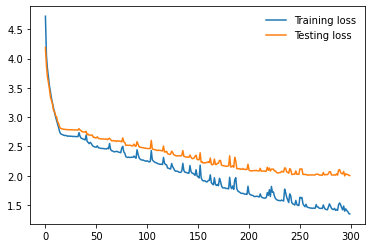

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Testing loss')
plt.legend(frameon=False)

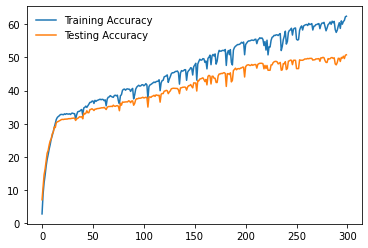

In [ ]:
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.legend(frameon=False)

In [ ]:
confusion_matrix = np.zeros([100, 100], int)
label_list, prediction_list = [], []
for (labels, predictions) in zip(test_labels, test_predictions):
  for (_label, prediction) in zip(labels, predictions):
    label_list.append(_label.item())
    prediction_list.append(prediction.item())
    confusion_matrix[_label.item(), prediction.item()] += 1 

In [ ]:
np.set_printoptions(threshold=sys.maxsize)
confusion_matrix

array([[21105,   214,    22,     0,     0,     3,   162,    82,     0,
            0,    50,    40,     0,     0,    55,     0,    11,     0,
            0,     1,     8,     0,     1,     1,   285,    45,    25,
            0,     0,     0,     0,     0,    11,     0,     0,    85,
           67,     0,     0,     0,     1,    18,     0,     0,    17,
          119,     1,     8,     0,     0,     0,     1,     0,   712,
          463,     0,     0,  1399,   199,     0,    33,   126,   366,
            0,     0,     1,     0,     0,     0,     0,   639,     0,
            0,     0,     0,     0,     0,     0,     3,     0,     0,
            0,    15,  2883,    80,     0,     0,     0,     0,     2,
            0,     1,   610,     0,    18,     0,     0,     0,     3,
            9],
       [  166, 16166,    21,    70,    19,   118,   398,    25,   237,
            0,   272,    14,     1,   105,  1121,     0,    29,     1,
           55,     8,     1,    36,     0,     9,     0,   17

In [ ]:
import seaborn as sns
plt.figure(figsize=(50,50))
sns.heatmap(confusion_matrix, cmap='Blues', annot=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(label_list, prediction_list))

              precision    recall  f1-score   support

           0       0.67      0.70      0.69     30000
           1       0.45      0.54      0.49     30000
           2       0.31      0.27      0.29     30000
           3       0.26      0.24      0.25     30000
           4       0.24      0.20      0.22     30000
           5       0.39      0.35      0.37     30000
           6       0.30      0.52      0.38     30000
           7       0.32      0.55      0.40     30000
           8       0.54      0.37      0.44     30000
           9       0.57      0.46      0.51     30000
          10       0.28      0.21      0.24     30000
          11       0.25      0.30      0.27     30000
          12       0.41      0.43      0.42     30000
          13       0.29      0.39      0.33     30000
          14       0.17      0.44      0.24     30000
          15       0.34      0.34      0.34     30000
          16       0.46      0.43      0.44     30000
          17       0.59    

**Precision and recall from above classification report - 41% (weighted average)**

In [13]:
max(test_accuracy)

50.74999999999999

**Maximum accuracy - 50.75%**

# References

#### *Dataset*
1. [CIFAR100](https://pytorch.org/docs/stable/_modules/torchvision/datasets/cifar.html#CIFAR100)

#### *Code*
1. https://github.com/dipuk0506/SpinalNet
2. https://pytorch.org/docs/stable/nn.html#convolution-layers
3. https://towardsdatascience.com/start-your-cnn-journey-with-pytorch-in-python-6f8364a79801

#### *Readings*
1. https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5
2.  https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf
3. https://discuss.pytorch.org/t/model-train-and-model-eval-vs-model-and-model-eval/5744/14
4. http://d2l.ai/chapter_convolutional-neural-networks/index.html
5. http://cs231n.stanford.edu/
6. https://arxiv.org/pdf/1512.03385.pdf
